In [1]:
# Imports packages
import sys
import sys #reimport sys so we have it when not running package installation/setup
import infofile # local file containing cross-sections, sums of weights, dataset IDs
import numpy as np # for numerical calculations such as histogramming
import matplotlib.pyplot as plt # for plotting
import matplotlib_inline # to edit the inline plot format

#suspicious this is necessary, never had to do it before!
matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg') # to make plots in pdf (vector) format

from matplotlib.ticker import AutoMinorLocator # for minor ticks
import uproot # for reading .root files
import awkward as ak # to represent nested data in columnar format
import vector # for 4-momentum calculations
import time
import pickle

In [2]:
MeV = 0.001
GeV = 1.0

In [3]:
# ATLAS Open Data directory for simulation and data
# this folder is viewable in a browser
path = "https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/"

#information on these datasets: https://atlas-opendata.web.cern.ch/docs/datasets/intro
skims = ['4lep','3lep','2lep','1lep','1largeRjet1lep','1lep1tau','GamGam']

In [4]:
samples = {
    'data': {
        'list' : ['data_A','data_B','data_C','data_D'], # data is from 2016, first four periods of data taking (ABCD)
    },
    'Zjets' : { # Z(ll) + jets
        'list' : ['Zee','Zmumu','Ztautau'],
        'color' : "#8fd7d7",
        'legend': r'$Z+$jets'
    },
    'Wjets' : { # W(lv)+jets
        'list' : ['Wplusenu','Wminusenu','Wplusmunu','Wminusmunu','Wplustaunu','Wminustaunu'],
        'color' : "#00b0be",
        'legend': r'$W+$jets'
    },
    'diboson_leptonic' : { # Diboson, both decay leptonically
        'list' : ['llll','lllv','llvv','lvvv'],
        'color' : "#ff8cal",
        'legend' : 'Diboson (fully leptonic)'
    },
    'diboson_semileptonic' : { # Diboson, one decays hadronically
        'list' : ['ZqqZll','WqqZll','WpqqWmlv','WplvWmqq','WlvZqq'],
        'color' : "#f45f74",
        'legend' : 'Diboson (semi-leptonic)'
    },
    'HZZ4l' : { # H -> ZZ -> llll
        'list' : ['ggH125_ZZ4lep','VBFH125_ZZ4lep','WH125_ZZ4lep','ZH125_ZZ4lep'],
        'color' : "#bdd373",
        'legend' : r'$H(125)\rightarrow ZZ \rightarrow llll$',
    },
    'Hyy': { #Higgs -> gamma gamma
        'list' : ['ggH125_gamgam','VBFH125_gamgam','ttH125_gamgam','ZH125J_Zincl_gamgam','WpH125J_Wincl_gamgam'],
        'color' : "#98c127",
        'legend' : r'$H(125)\rightarrow ZZ \rightarrow llll$',

    },
    'HWW': { #Higgs -> WW -> lv lv
        'list' : ['VBFH125_WW2lep','ggH125_WW2lep','WpH125J_qqWW2lep','WpH125J_lvWW2lep','ZH125J_qqWW2lep','ZH125J_llWW2lep','ZH125J_vvWW2lep'],
        'color' : "#ffcd8e",
        'legend' : r'$H(125)\rightarrow WW \rightarrow lvlv$',
    },
    'top':{ #processes with a top quark (single top, ttbar)
        'list' : ['ttbar_lep','single_top_tchan','single_antitop_tchan','single_top_wtchan','single_antitop_wtchan',
                  'single_top_schan','single_antitop_schan','ttW','ttee','ttmumu'],
        'color' : "#ffb255",
        'legend' : r'Top processes',
    },  
}

In [5]:
variables        = ["jet_MV2c10", "jet_pt", "jet_eta", "jet_E", "jet_phi", "lep_type", "lep_pt", "lep_eta", "lep_phi", "lep_E", "met_et", "met_phi"]
weight_variables = ["mcWeight", "scaleFactor_PILEUP", "scaleFactor_ELE", "scaleFactor_MUON", "scaleFactor_LepTRIGGER"]

In [6]:
# Sets up the tree for data set wanted
value = samples["data"]["list"][1] # change this to the dataset you want to use 
                                   # e.g. 0-> data_A, 1-> data_B, etc.
                                   
data_path = path + '1lep' + "/Data/" + value + "."+ '1lep' +".root"
tree = uproot.open(data_path + ":mini")

In [7]:
# Loads in the data
raw_data = {}
for var in variables:
    data_array = tree.arrays(var, library="ak")[var]
    raw_data[var] = data_array

In [ ]:
# loads in the Wjets MC data
val1      = samples["Wjets"]["list"][0]
MC_path1 = path + "1lep/MC/mc_"+str(infofile.infos[val1]["DSID"])+"."+val1+".1lep.root"
treeMC1  = uproot.open(MC_path1 + ":mini")

val2      = samples["Wjets"]["list"][1]
MC_path2 = path + "1lep/MC/mc_"+str(infofile.infos[val2]["DSID"])+"."+val2+".1lep.root"
treeMC2  = uproot.open(MC_path2 + ":mini")

val3      = samples["Wjets"]["list"][2]
MC_path3 = path + "1lep/MC/mc_"+str(infofile.infos[val3]["DSID"])+"."+val3+".1lep.root"
treeMC3  = uproot.open(MC_path3 + ":mini")

val4      = samples["Wjets"]["list"][3]
MC_path4 = path + "1lep/MC/mc_"+str(infofile.infos[val4]["DSID"])+"."+val4+".1lep.root"
treeMC4  = uproot.open(MC_path4 + ":mini")

val5      = samples["Wjets"]["list"][4]
MC_path5 = path + "1lep/MC/mc_"+str(infofile.infos[val5]["DSID"])+"."+val5+".1lep.root"
treeMC5  = uproot.open(MC_path5 + ":mini")

# Did not go beyond this as val5 was empty after cuts. I am assuming the anti-particle counter to this data will do the same.

In [9]:
# Wjets1
MCdata1_raw  = {}
raw_weights1 = {}
for var in variables:
    data_array = treeMC1.arrays(var, library="ak")[var]
    MCdata1_raw[var] = data_array
    
for var in weight_variables:
    data_array = treeMC1.arrays(var, library="ak")[var]
    raw_weights1[var] = data_array

###########################################################
# Wjets2
MCdata2_raw  = {}
raw_weights2 = {}
for var in variables:
    data_array = treeMC2.arrays(var, library="ak")[var]
    MCdata2_raw[var] = data_array

for var in weight_variables:
    data_array = treeMC2.arrays(var, library="ak")[var]
    raw_weights2[var] = data_array

###########################################################
# Wjets2
MCdata3_raw  = {}
raw_weights3 = {}
for var in variables:
    data_array = treeMC3.arrays(var, library="ak")[var]
    MCdata3_raw[var] = data_array

for var in weight_variables:
    data_array = treeMC3.arrays(var, library="ak")[var]
    raw_weights3[var] = data_array

###########################################################
# Wjets4
MCdata4_raw  = {}
raw_weights4 = {}
for var in variables:
    data_array = treeMC4.arrays(var, library="ak")[var]
    MCdata4_raw[var] = data_array

for var in weight_variables:
    data_array = treeMC4.arrays(var, library="ak")[var]
    raw_weights4[var] = data_array

###########################################################
# Wjets5
MCdata5_raw  = {}
raw_weights5 = {}
for var in variables:
    data_array = treeMC5.arrays(var, library="ak")[var]
    MCdata5_raw[var] = data_array

for var in weight_variables:
    data_array = treeMC5.arrays(var, library="ak")[var]
    raw_weights5[var] = data_array

In [ ]:
# Gets the tq data
# Single top t-channel
val6      = samples["top"]["list"][1]
MC_path6 = path + "1lep/MC/mc_"+str(infofile.infos[val6]["DSID"])+"."+val6+".1lep.root"
treeMC6  = uproot.open(MC_path6 + ":mini")

# Single antitop t-channel
val7      = samples["top"]["list"][2]
MC_path7 = path + "1lep/MC/mc_"+str(infofile.infos[val7]["DSID"])+"."+val7+".1lep.root"
treeMC7  = uproot.open(MC_path7 + ":mini")

In [11]:
###########################################################
# tq
MCdata6_raw  = {}
raw_weights6 = {}
for var in variables:
    data_array = treeMC6.arrays(var, library="ak")[var]
    MCdata6_raw[var] = data_array

for var in weight_variables:
    data_array = treeMC6.arrays(var, library="ak")[var]
    raw_weights6[var] = data_array

###########################################################
# t~q
MCdata7_raw  = {}
raw_weights7 = {}
for var in variables:
    data_array = treeMC7.arrays(var, library="ak")[var]
    MCdata7_raw[var] = data_array

for var in weight_variables:
    data_array = treeMC7.arrays(var, library="ak")[var]
    raw_weights7[var] = data_array

In [ ]:
# Sets up the ttbar leptonic decay
val8      = samples["top"]["list"][0]
MC_path8 = path + "1lep/MC/mc_"+str(infofile.infos[val8]["DSID"])+"."+val8+".1lep.root"
treeMC8  = uproot.open(MC_path8 + ":mini")

In [13]:
###########################################################
# tt~l
MCdata8_raw  = {}
raw_weights8 = {}
for var in variables:
    data_array = treeMC8.arrays(var, library="ak")[var]
    MCdata8_raw[var] = data_array

for var in weight_variables:
    data_array = treeMC8.arrays(var, library="ak")[var]
    raw_weights8[var] = data_array

In [14]:
# Sets up the Wt channel
val9      = samples["top"]["list"][3]
MC_path9 = path + "1lep/MC/mc_"+str(infofile.infos[val9]["DSID"])+"."+val9+".1lep.root"
treeMC9  = uproot.open(MC_path9 + ":mini")

# Single antitop t-channel
val10      = samples["top"]["list"][4]
MC_path10 = path + "1lep/MC/mc_"+str(infofile.infos[val10]["DSID"])+"."+val10+".1lep.root"
treeMC10  = uproot.open(MC_path10 + ":mini")

In [15]:
###########################################################
# tq
MCdata9_raw  = {}
raw_weights9 = {}
for var in variables:
    data_array = treeMC9.arrays(var, library="ak")[var]
    MCdata9_raw[var] = data_array

for var in weight_variables:
    data_array = treeMC9.arrays(var, library="ak")[var]
    raw_weights9[var] = data_array

###########################################################
# t~q
MCdata10_raw  = {}
raw_weights10 = {}
for var in variables:
    data_array = treeMC10.arrays(var, library="ak")[var]
    MCdata10_raw[var] = data_array

for var in weight_variables:
    data_array = treeMC10.arrays(var, library="ak")[var]
    raw_weights10[var] = data_array

In [16]:
# Sets up the Wt channel
val11      = samples["top"]["list"][5]
MC_path11 = path + "1lep/MC/mc_"+str(infofile.infos[val11]["DSID"])+"."+val11+".1lep.root"
treeMC11  = uproot.open(MC_path11 + ":mini")

# Single antitop t-channel
val12      = samples["top"]["list"][6]
MC_path12 = path + "1lep/MC/mc_"+str(infofile.infos[val12]["DSID"])+"."+val12+".1lep.root"
treeMC12  = uproot.open(MC_path12 + ":mini")

In [17]:
###########################################################
# s-chan
MCdata11_raw  = {}
raw_weights11 = {}
for var in variables:
    data_array = treeMC11.arrays(var, library="ak")[var]
    MCdata11_raw[var] = data_array

for var in weight_variables:
    data_array = treeMC11.arrays(var, library="ak")[var]
    raw_weights11[var] = data_array

###########################################################
# anti s-chan
MCdata12_raw  = {}
raw_weights12 = {}
for var in variables:
    data_array = treeMC12.arrays(var, library="ak")[var]
    MCdata12_raw[var] = data_array

for var in weight_variables:
    data_array = treeMC12.arrays(var, library="ak")[var]
    raw_weights12[var] = data_array

In [18]:
# loads in the Z(ll)+jets MC data
val13      = samples["Zjets"]["list"][0]
MC_path13 = path + "1lep/MC/mc_"+str(infofile.infos[val13]["DSID"])+"."+val13+".1lep.root"
treeMC13  = uproot.open(MC_path13 + ":mini")

val14      = samples["Zjets"]["list"][1]
MC_path14 = path + "1lep/MC/mc_"+str(infofile.infos[val14]["DSID"])+"."+val14+".1lep.root"
treeMC14  = uproot.open(MC_path14 + ":mini")

val15      = samples["Zjets"]["list"][2]
MC_path15 = path + "1lep/MC/mc_"+str(infofile.infos[val15]["DSID"])+"."+val15+".1lep.root"
treeMC15  = uproot.open(MC_path15 + ":mini")

In [19]:
###########################################################
# Zee
MCdata13_raw  = {}
raw_weights13 = {}
for var in variables:
    data_array = treeMC13.arrays(var, library="ak")[var]
    MCdata13_raw[var] = data_array

for var in weight_variables:
    data_array = treeMC13.arrays(var, library="ak")[var]
    raw_weights13[var] = data_array

###########################################################
# Zmumu
MCdata14_raw  = {}
raw_weights14 = {}
for var in variables:
    data_array = treeMC14.arrays(var, library="ak")[var]
    MCdata14_raw[var] = data_array

for var in weight_variables:
    data_array = treeMC14.arrays(var, library="ak")[var]
    raw_weights14[var] = data_array

###########################################################
# Ztautau
MCdata15_raw  = {}
raw_weights15 = {}
for var in variables:
    data_array = treeMC15.arrays(var, library="ak")[var]
    MCdata15_raw[var] = data_array

for var in weight_variables:
    data_array = treeMC15.arrays(var, library="ak")[var]
    raw_weights15[var] = data_array

In [ ]:
def cut_dataset(data, weights = None, btag_thr = 0.7):
    # Makes a copy of the input data
    raw_data = data.copy()
    # Makes a copy of the input weights
    if weights is not None:
        raw_weights = weights.copy()

    # 2-jet cut
    n_total = len(data["jet_pt"])
    mask1 = ak.num(data["jet_pt"]) == 2

    for key in data:
        data[key] = data[key][mask1]

    n_pass = ak.sum(mask1)
    n_cut = n_total - n_pass
    print(f"Number of events cut: {n_cut:0.2e}")

    ##################################################################
    # lepton pt cut
    n_total = len(data["jet_pt"])
    mask2 = ak.any((data["lep_pt"] * MeV) > 35, axis=1)

    for key in data:
        data[key] = data[key][mask2]

    n_pass = ak.sum(mask2)
    n_cut = n_total - n_pass
    print(f"Number of events cut: {n_cut:0.2e}")

    ##################################################################
    # Missing transverse momentum cut
    n_total = len(data["jet_pt"])
    mask3 = (data["met_et"] * MeV) > 30

    for key in data:
        data[key] = data[key][mask3]

    n_pass = ak.sum(mask3)
    n_cut = n_total - n_pass
    print(f"Number of events cut: {n_cut:0.2e}")

    ##################################################################
    # Transverse mass of W boson cut
    n_total = len(data["jet_pt"])
    # 1) Get the lepton and MET data

    lep_pt   = data["lep_pt"] * MeV
    lep_phi  = data["lep_phi"]
    met_et   = data["met_et"] * MeV
    met_phi  = data["met_phi"]

    # 2) Compute delta phi = |phi_l − phi_MET| in [0,pi]
    dphi = np.abs(lep_phi - met_phi)
    dphi = ak.where(dphi > np.pi, 2*np.pi - dphi, dphi)

    # 3) Transverse mass: mT = sqrt[2 pT MET (1−cos delta phi)]
    mT = np.sqrt(2 * lep_pt * met_et * (1 - np.cos(dphi)))

    # 4) Build the mask
    mT1  = mT[:, 0]         # collapse the inner lists
    mask4 = mT1 > 60        # now a simple per‑event boolean array

    for key in data:
        data[key] = data[key][mask4]

    n_pass = ak.sum(mask4)
    n_cut = n_total - n_pass
    print(f"Number of events cut: {n_cut:.2e}")

    ##################################################################
    # jet pt cut
    n_total = len(data["jet_pt"])
    mask5 = ak.all((data["jet_pt"] * MeV) > 30, axis=1)

    for key in data:
        data[key] = data[key][mask5]

    n_pass = ak.sum(mask5)
    n_cut = n_total - n_pass
    print(f"Number of events cut: {n_cut:.2e}")

    ##################################################################
    # b‑tagged jet cut
    n_total = len(data["jet_pt"])
    btag_thr = btag_thr  # btagging selection
    mask6 = ak.sum(data["jet_MV2c10"] > btag_thr, axis=1) == 1

    # apply mask6
    for key in data:
        data[key] = data[key][mask6]

    n_pass = ak.sum(mask6)
    n_cut  = n_total - n_pass
    print(f"Number of events cut: {n_cut:.2e}")

    ##################################################################
    # untagged jet pseudo-rapidity cut
    jet_bmask = data["jet_MV2c10"] > btag_thr # mask for b-tagged jets
    jet_eta_data = data["jet_eta"] # pseudo-rapidity in the data

    eta_untag_data = ak.where(
        jet_bmask[:,0],           # condition: is jet0 b‑tagged?
        jet_eta_data[:,1],        # if True, un‑tagged = jet1
        jet_eta_data[:,0]         # else, un‑tagged = jet0
    )

    # Build your |η| > 1.5 mask
    mask7 = abs(eta_untag_data) > 1.5

    for key in data:
        data[key] = data[key][mask7]

    n_pass = ak.sum(mask7)
    n_cut = n_total - n_pass
    print(f"Number of events cut: {n_cut:.2e}")   

    ##################################################################
    # eta seperation cut
    n_total = len(data["jet_pt"])

    # find b-tagged jets
    jet_eta      = data["jet_eta"]                     # shape (n_events, 2)
    jet_bmask    = data["jet_MV2c10"] > btag_thr       # same shape

    # sets up tagged eta and utagged eta
    eta_tag   = ak.where(jet_bmask[:, 0], jet_eta[:, 0], jet_eta[:, 1])
    eta_untag = ak.where(jet_bmask[:, 0], jet_eta[:, 1], jet_eta[:, 0])

    # Compute pseudo-rapidity difference
    delta_eta = abs(eta_tag - eta_untag)

    # generates the mask
    mask8 = delta_eta > 1.5

    for key in data:
        data[key] = data[key][mask8]

    n_pass = ak.sum(mask8)
    n_cut  = n_total - n_pass
    print(f"Number of events cut: {n_cut:.2e}") 

    ##################################################################
    # scalar sum cut
    n_total = len(data["jet_pt"])

    lep_pt   = data["lep_pt"] * MeV                   # shape (n_events,)
    jet_pt   = data["jet_pt"] * MeV                   # shape (n_events, 2)
    met_et   = data["met_et"] * MeV                   # shape (n_events,)

    # HT per event as the sum of all leptons + jets + MET
    lep_sum    = ak.sum(data["lep_pt"] * MeV, axis=1)   # now shape (n_events,)
    jets_sum   = ak.sum(data["jet_pt"]  * MeV, axis=1)  # shape (n_events,)
    met_scalar = data["met_et"] * MeV                   # shape (n_events,)

    HT_data = lep_sum + jets_sum + met_scalar           # shape (n_events,)
    mask9   = HT_data > 195

    for key in data:
        data[key] = data[key][mask9]

    n_pass = ak.sum(mask9)
    n_cut  = n_total - n_pass
    print(f"Number of events cut: {n_cut:.2e}") 

    ##################################################################
    # Invariant mass of lb cut
    n_total = len(data["jet_pt"])

    lep_pt   = data["lep_pt"] * MeV
    lep_eta  = data["lep_eta"]
    lep_phi  = data["lep_phi"]
    lep_E    = data["lep_E"] * MeV

    jet_pt   = data["jet_pt"] * MeV          # shape (n_events,2)
    jet_eta  = data["jet_eta"]
    jet_phi  = data["jet_phi"]
    jet_E    = data["jet_E"] * MeV
    jet_bmask = data["jet_MV2c10"] > btag_thr  # same btag_thr as before

    # calcs px, py, pz for lepton and jets
    lep_px = lep_pt * np.cos(lep_phi)
    lep_py = lep_pt * np.sin(lep_phi)
    lep_pz = lep_pt * np.sinh(lep_eta)

    jet_px = jet_pt * np.cos(jet_phi)
    jet_py = jet_pt * np.sin(jet_phi)
    jet_pz = jet_pt * np.sinh(jet_eta)

    # Select the b‑tagged jets
    b_px = ak.where(jet_bmask[:,0], jet_px[:,0], jet_px[:,1])
    b_py = ak.where(jet_bmask[:,0], jet_py[:,0], jet_py[:,1])
    b_pz = ak.where(jet_bmask[:,0], jet_pz[:,0], jet_pz[:,1])
    b_E  = ak.where(jet_bmask[:,0], jet_E[:,0],  jet_E[:,1])

    # Sum components
    sum_E  = lep_E + b_E
    sum_px = lep_px + b_px
    sum_py = lep_py + b_py
    sum_pz = lep_pz + b_pz

    # Compute m_lb
    mlb = np.sqrt(sum_E**2 - (sum_px**2 + sum_py**2 + sum_pz**2))

    # mlb has shape (n_events, n_leptons) [pretty sure]
    mlb1 = mlb[:, 0]         # collapse the inner lists


    mask10 = mlb1 > 150

    # Apply to data
    for key in data:
        data[key] = data[key][mask10]

    n_pass = ak.sum(mask10)
    n_cut  = n_total - n_pass
    print(f"Number of events cut: {n_cut:.2e}") 

    # applies weight cuts if necessary
    if weights is not None:
        for key in weights:
            weights[key] = weights[key][mask1]
            weights[key] = weights[key][mask2]
            weights[key] = weights[key][mask3]
            weights[key] = weights[key][mask4]
            weights[key] = weights[key][mask5]
            weights[key] = weights[key][mask6]
            weights[key] = weights[key][mask7]
            weights[key] = weights[key][mask8]
            weights[key] = weights[key][mask9]
            weights[key] = weights[key][mask10]
        
        weights = weights["mcWeight"]*weights["scaleFactor_PILEUP"]*weights["scaleFactor_ELE"]*weights["scaleFactor_MUON"]*weights["scaleFactor_LepTRIGGER"]
        return(data, weights, raw_data, raw_weights)

    return(data, raw_data)

In [ ]:
# Computes m_lb for the data and MC datasets
def compute_mlb(data, btag_thr = 0.7):
    # Get the lepton and jet vals
    lep_pt   = data["lep_pt"] * MeV
    lep_eta  = data["lep_eta"]
    lep_phi  = data["lep_phi"]
    lep_E    = data["lep_E"] * MeV

    jet_pt   = data["jet_pt"] * MeV          # shape (n_events,2)
    jet_eta  = data["jet_eta"]
    jet_phi  = data["jet_phi"]
    jet_E    = data["jet_E"] * MeV
    jet_bmask = data["jet_MV2c10"] > btag_thr  # same btag_thr as before

    # Build px, py, pz for lepton and jets
    lep_px = lep_pt * np.cos(lep_phi)
    lep_py = lep_pt * np.sin(lep_phi)
    lep_pz = lep_pt * np.sinh(lep_eta)

    jet_px = jet_pt * np.cos(jet_phi)
    jet_py = jet_pt * np.sin(jet_phi)
    jet_pz = jet_pt * np.sinh(jet_eta)

    # Select the b‑tagged jets
    b_px = ak.where(jet_bmask[:,0], jet_px[:,0], jet_px[:,1])
    b_py = ak.where(jet_bmask[:,0], jet_py[:,0], jet_py[:,1])
    b_pz = ak.where(jet_bmask[:,0], jet_pz[:,0], jet_pz[:,1])
    b_E  = ak.where(jet_bmask[:,0], jet_E[:,0],  jet_E[:,1])

    # Sum
    sum_E  = lep_E + b_E
    sum_px = lep_px + b_px
    sum_py = lep_py + b_py
    sum_pz = lep_pz + b_pz
    # Compute m_lb
    mlb = np.sqrt(sum_E**2 - (sum_px**2 + sum_py**2 + sum_pz**2))

    return(mlb)

In [ ]:
# produces a plot of mlb
def plot_mlb(data, MCdata1, weights1, MeV=0.001):
    # Define bins & centers
    bins       = np.arange(0, 500, 20)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])

    # Prepare arrays (in GeV)
    data_vals = compute_mlb(data)
    mc_vals1  = compute_mlb(MCdata1)
    print(mc_vals1)

    # Compute histograms & Poisson errors
    dat_counts, _ = np.histogram(data_vals, bins=bins)
    dat_errors    = np.sqrt(dat_counts)

    mc_counts1, _  = np.histogram(mc_vals1[:,0],
                                 bins=bins,
                                 weights=weights1)
    mc_errors1     = np.sqrt(mc_counts1)


    # Set up figure with main + residual axes
    fig, (ax, ax_resid) = plt.subplots(
        nrows=2, sharex=True, figsize=(10, 8),
        gridspec_kw={"height_ratios": [3, 1]}
    )

    # ─── Main panel ─────────────────────────────────────────────────────
    # Data: points with error bars
    ax.errorbar(bin_centers, dat_counts, yerr=dat_errors,
                fmt="o", color="k", capsize=4, label="Data")

    # MC: filled histogram
    ax.hist(mc_vals1[:,0], bins=bins, weights=weights1,
            alpha=0.7, color="limegreen", label="MC prediction", stacked=True)
    
    # MC uncertainty band: +/-sqrt(N)
    ax.bar(bin_centers, 2*mc_errors1,
           bottom=mc_counts1-mc_errors1,
           width=np.diff(bins)[0], hatch="////",
           color="none", alpha=0.5, label="MC uncertainty")
    ax.set_ylabel("Events / bin")
    ax.legend()
    ax.grid(alpha=0.3)
    # ─── Residuals panel ────────────────────────────────────────────────
    residual     = dat_counts - mc_counts1
    resid_errors = np.sqrt(dat_errors**2 + mc_errors1**2)

    ax_resid.errorbar(bin_centers, residual, yerr=resid_errors,
                        fmt="o", color="black", capsize=4)
    ax_resid.axhline(0, color="gray", linewidth=1)
    ax_resid.set_xlabel("m_lb [GeV]")
    ax_resid.set_ylabel("Residuals")
    ax_resid.grid(alpha=0.3)
    print(len(data["lep_pt"]))

    plt.tight_layout()
    plt.show()

## Data

In [106]:
b_tag_selection = 0.77

In [ ]:
# Applies cuts to the data
data, raw_data = cut_dataset(raw_data, btag_thr = b_tag_selection)

Number of events cut: 3.09e+07
Number of events cut: 1.81e+06
Number of events cut: 9.91e+05
Number of events cut: 2.86e+05
Number of events cut: 6.84e+05
Number of events cut: 2.15e+05
Number of events cut: 2.32e+05
Number of events cut: 4.52e+03
Number of events cut: 1.20e+03
Number of events cut: 1.71e+03


## W+jets channel

In [108]:
# lumi = 0.5 # fb-1 # data_A only
lumi = 1.9 # fb-1 # data_B only
# lumi = 2.9 # fb-1 # data_C only
# lumi = 4.7 # fb-1 # data_D only
# lumi = 10 # fb-1 # data_A,data_B,data_C,data_D

info = infofile.infos[val1] # open infofile
xsec_weight1 = (lumi*1000*info["xsec"])/(info["red_eff"]*info["sumw"]) #*1000 to go from fb-1 to pb-1
info = infofile.infos[val2] # open infofile
xsec_weight2 = (lumi*1000*info["xsec"])/(info["red_eff"]*info["sumw"]) #*1000 to go from fb-1 to pb-1
info = infofile.infos[val3] # open infofile
xsec_weight3 = (lumi*1000*info["xsec"])/(info["red_eff"]*info["sumw"]) #*1000 to go from fb-1 to pb-1
info = infofile.infos[val4] # open infofile
xsec_weight4 = (lumi*1000*info["xsec"])/(info["red_eff"]*info["sumw"]) #*1000 to go from fb-1 to pb-1
info = infofile.infos[val5] # open infofile
xsec_weight5 = (lumi*1000*info["xsec"])/(info["red_eff"]*info["sumw"]) #*1000 to go from fb-1 to pb-1

In [109]:
# Sets up the W+jets data
dataMC1, weights1, MCdata1_raw, raw_weights1 = cut_dataset(MCdata1_raw, raw_weights1, btag_thr = b_tag_selection)
dataMC2, weights2, MCdata2_raw, raw_weights2 = cut_dataset(MCdata2_raw, raw_weights2, btag_thr = b_tag_selection)
dataMC3, weights3, MCdata3_raw, raw_weights3 = cut_dataset(MCdata3_raw, raw_weights3, btag_thr = b_tag_selection)
dataMC4, weights4, MCdata4_raw, raw_weights4 = cut_dataset(MCdata4_raw, raw_weights4, btag_thr = b_tag_selection)
dataMC5, weights5, MCdata5_raw, raw_weights5 = cut_dataset(MCdata5_raw, raw_weights5, btag_thr = b_tag_selection)


# concatenate the two MC datasets
dataMC = {}
weights = ak.concatenate([weights1*xsec_weight1, weights2*xsec_weight2, weights3*xsec_weight3, weights4*xsec_weight4, weights5*xsec_weight5], axis=0)
for key in dataMC1:
    dataMC[key] = ak.concatenate([dataMC1[key], dataMC2[key], dataMC3[key], dataMC4[key], dataMC5[key]], axis=0)


Number of events cut: 1.18e+07
Number of events cut: 2.71e+05
Number of events cut: 2.14e+05
Number of events cut: 6.44e+04
Number of events cut: 2.63e+05
Number of events cut: 5.58e+04
Number of events cut: 5.79e+04
Number of events cut: 4.15e+02
Number of events cut: 2.08e+02
Number of events cut: 1.55e+02
Number of events cut: 8.72e+06
Number of events cut: 1.79e+05
Number of events cut: 1.84e+05
Number of events cut: 4.74e+04
Number of events cut: 2.15e+05
Number of events cut: 4.57e+04
Number of events cut: 4.75e+04
Number of events cut: 3.45e+02
Number of events cut: 1.68e+02
Number of events cut: 1.33e+02
Number of events cut: 1.26e+07
Number of events cut: 2.74e+05
Number of events cut: 1.99e+05
Number of events cut: 6.17e+04
Number of events cut: 2.56e+05
Number of events cut: 5.22e+04
Number of events cut: 5.40e+04
Number of events cut: 3.83e+02
Number of events cut: 1.78e+02
Number of events cut: 1.50e+02
Number of events cut: 1.04e+07
Number of events cut: 2.03e+05
Number o

## tq channel

In [110]:
# lumi = 0.5 # fb-1 # data_A only
lumi = 1.9 # fb-1 # data_B only
# lumi = 2.9 # fb-1 # data_C only
# lumi = 4.7 # fb-1 # data_D only
# lumi = 10 # fb-1 # data_A,data_B,data_C,data_D

info = infofile.infos[val6] # open infofile
xsec_weight6 = (lumi*1000*info["xsec"])/(info["red_eff"]*info["sumw"]) #*1000 to go from fb-1 to pb-1
info = infofile.infos[val7] # open infofile
xsec_weight7 = (lumi*1000*info["xsec"])/(info["red_eff"]*info["sumw"]) #*1000 to go from fb-1 to pb-1

In [111]:
# Sets up the tq data
dataMC6, weights6, MCdata6_raw, raw_weights6 = cut_dataset(MCdata6_raw, raw_weights6, btag_thr = b_tag_selection)
dataMC7, weights7, MCdata7_raw, raw_weights7 = cut_dataset(MCdata7_raw, raw_weights7, btag_thr = b_tag_selection)

# concatenate the two MC datasets
dataMCtq = {}
weightstq = ak.concatenate([weights6*xsec_weight6, weights7*xsec_weight7], axis=0)
for key in dataMC1:
    dataMCtq[key] = ak.concatenate([dataMC6[key], dataMC7[key]], axis=0)

Number of events cut: 9.79e+05
Number of events cut: 1.26e+05
Number of events cut: 1.01e+05
Number of events cut: 7.54e+04
Number of events cut: 8.31e+04
Number of events cut: 4.65e+04
Number of events cut: 8.40e+04
Number of events cut: 1.13e+04
Number of events cut: 3.28e+03
Number of events cut: 1.64e+04
Number of events cut: 1.01e+06
Number of events cut: 1.35e+05
Number of events cut: 1.13e+05
Number of events cut: 8.03e+04
Number of events cut: 8.71e+04
Number of events cut: 4.93e+04
Number of events cut: 9.36e+04
Number of events cut: 1.06e+04
Number of events cut: 4.07e+03
Number of events cut: 1.97e+04


## tt~ leptonic channel

In [112]:
# lumi = 0.5 # fb-1 # data_A only
lumi = 1.9 # fb-1 # data_B only
# lumi = 2.9 # fb-1 # data_C only
# lumi = 4.7 # fb-1 # data_D only
# lumi = 10 # fb-1 # data_A,data_B,data_C,data_D

info = infofile.infos[val8] # open infofile
xsec_weight8 = (lumi*1000*info["xsec"])/(info["red_eff"]*info["sumw"]) #*1000 to go from fb-1 to pb-1

In [113]:
# Sets up the tt~ data
dataMC8, weights8, MCdata8_raw, raw_weights8 = cut_dataset(MCdata8_raw, raw_weights8, btag_thr = b_tag_selection)

# concatenate the two MC datasets
dataMCtt = {}
weightstt = weights8*xsec_weight8
for key in dataMC1:
    dataMCtt[key] = dataMC8[key]

Number of events cut: 1.44e+07
Number of events cut: 2.54e+05
Number of events cut: 2.06e+05
Number of events cut: 2.60e+05
Number of events cut: 2.03e+05
Number of events cut: 2.11e+05
Number of events cut: 3.72e+05
Number of events cut: 5.93e+04
Number of events cut: 2.27e+03
Number of events cut: 2.04e+04


## Wt channel

In [114]:
# lumi = 0.5 # fb-1 # data_A only
lumi = 1.9 # fb-1 # data_B only
# lumi = 2.9 # fb-1 # data_C only
# lumi = 4.7 # fb-1 # data_D only
# lumi = 10 # fb-1 # data_A,data_B,data_C,data_D

info = infofile.infos[val9] # open infofile
xsec_weight9 = (lumi*1000*info["xsec"])/(info["red_eff"]*info["sumw"]) #*1000 to go from fb-1 to pb-1
info = infofile.infos[val10] # open infofile
xsec_weight10 = (lumi*1000*info["xsec"])/(info["red_eff"]*info["sumw"]) #*1000 to go from fb-1 to pb-1

In [115]:
# Sets up the Wt data
dataMC9, weights9, MCdata9_raw, raw_weights9 = cut_dataset(MCdata9_raw, raw_weights9, btag_thr = b_tag_selection)
dataMC10, weights10, MCdata10_raw, raw_weights10 = cut_dataset(MCdata10_raw, raw_weights10, btag_thr = b_tag_selection)

# concatenate the two MC datasets
dataMCWt = {}
weightsWt = ak.concatenate([weights9*xsec_weight9, weights10*xsec_weight10], axis=0)
for key in dataMC1:
    dataMCWt[key] = ak.concatenate([dataMC9[key], dataMC10[key]], axis=0)

Number of events cut: 7.35e+05
Number of events cut: 2.82e+04
Number of events cut: 3.12e+04
Number of events cut: 3.02e+04
Number of events cut: 2.72e+04
Number of events cut: 1.89e+04
Number of events cut: 3.93e+04
Number of events cut: 5.49e+03
Number of events cut: 2.65e+02
Number of events cut: 1.35e+03
Number of events cut: 7.45e+05
Number of events cut: 2.86e+04
Number of events cut: 3.16e+04
Number of events cut: 3.03e+04
Number of events cut: 2.77e+04
Number of events cut: 1.92e+04
Number of events cut: 3.99e+04
Number of events cut: 5.74e+03
Number of events cut: 2.65e+02
Number of events cut: 1.39e+03


## s-channel

In [116]:
# lumi = 0.5 # fb-1 # data_A only
lumi = 1.9 # fb-1 # data_B only
# lumi = 2.9 # fb-1 # data_C only
# lumi = 4.7 # fb-1 # data_D only
# lumi = 10 # fb-1 # data_A,data_B,data_C,data_D

info = infofile.infos[val11] # open infofile
xsec_weight11 = (lumi*1000*info["xsec"])/(info["red_eff"]*info["sumw"]) #*1000 to go from fb-1 to pb-1
info = infofile.infos[val12] # open infofile
xsec_weight12 = (lumi*1000*info["xsec"])/(info["red_eff"]*info["sumw"]) #*1000 to go from fb-1 to pb-1

In [117]:
# Sets up the s-chan data
dataMC11, weights11, MCdata11_raw, raw_weights11 = cut_dataset(MCdata11_raw, raw_weights11, btag_thr = b_tag_selection)
dataMC12, weights12, MCdata12_raw, raw_weights12 = cut_dataset(MCdata12_raw, raw_weights12, btag_thr = b_tag_selection)

# concatenate the two MC datasets
dataMCs = {}
weights_s = ak.concatenate([weights11*xsec_weight11, weights12*xsec_weight12], axis=0)
for key in dataMC1:
    dataMCs[key] = ak.concatenate([dataMC11[key], dataMC12[key]], axis=0)

Number of events cut: 1.76e+05
Number of events cut: 2.45e+04
Number of events cut: 2.07e+04
Number of events cut: 1.45e+04
Number of events cut: 1.37e+04
Number of events cut: 1.34e+04
Number of events cut: 2.10e+04
Number of events cut: 2.60e+03
Number of events cut: 2.31e+02
Number of events cut: 4.73e+02
Number of events cut: 1.79e+05
Number of events cut: 2.54e+04
Number of events cut: 2.19e+04
Number of events cut: 1.47e+04
Number of events cut: 1.50e+04
Number of events cut: 1.44e+04
Number of events cut: 2.28e+04
Number of events cut: 2.58e+03
Number of events cut: 2.70e+02
Number of events cut: 6.82e+02


## Z($\ell\ell$) + jets

In [118]:
# lumi = 0.5 # fb-1 # data_A only
lumi = 1.9 # fb-1 # data_B only
# lumi = 2.9 # fb-1 # data_C only
# lumi = 4.7 # fb-1 # data_D only
# lumi = 10 # fb-1 # data_A,data_B,data_C,data_D

info = infofile.infos[val13] # open infofile
xsec_weight13 = (lumi*1000*info["xsec"])/(info["red_eff"]*info["sumw"]) #*1000 to go from fb-1 to pb-1
info = infofile.infos[val14] # open infofile
xsec_weight14 = (lumi*1000*info["xsec"])/(info["red_eff"]*info["sumw"]) #*1000 to go from fb-1 to pb-1
info = infofile.infos[val15] # open infofile
xsec_weight15 = (lumi*1000*info["xsec"])/(info["red_eff"]*info["sumw"]) #*1000 to go from fb-1 to pb-1

In [119]:
# Sets up the s-chan data
dataMC13, weights13, MCdata13_raw, raw_weights13 = cut_dataset(MCdata13_raw, raw_weights13, btag_thr = b_tag_selection)
dataMC14, weights14, MCdata14_raw, raw_weights14 = cut_dataset(MCdata14_raw, raw_weights14, btag_thr = b_tag_selection)
dataMC15, weights15, MCdata15_raw, raw_weights15 = cut_dataset(MCdata15_raw, raw_weights15, btag_thr = b_tag_selection)

# concatenate the two MC datasets
dataMCZ = {}
weights_Z = ak.concatenate([weights13*xsec_weight13, weights14*xsec_weight14, weights15*xsec_weight15], axis=0)
for key in dataMC1:
    dataMCZ[key] = ak.concatenate([dataMC13[key], dataMC14[key], dataMC15[key]], axis=0)

Number of events cut: 1.41e+07
Number of events cut: 5.85e+05
Number of events cut: 1.19e+06
Number of events cut: 3.70e+05
Number of events cut: 1.50e+05
Number of events cut: 7.59e+04
Number of events cut: 8.00e+04
Number of events cut: 1.02e+03
Number of events cut: 2.43e+02
Number of events cut: 2.14e+02
Number of events cut: 1.15e+07
Number of events cut: 3.58e+05
Number of events cut: 4.94e+05
Number of events cut: 1.03e+05
Number of events cut: 2.96e+05
Number of events cut: 4.73e+04
Number of events cut: 4.93e+04
Number of events cut: 5.24e+02
Number of events cut: 2.19e+02
Number of events cut: 1.53e+02
Number of events cut: 7.69e+05
Number of events cut: 1.19e+05
Number of events cut: 5.33e+04
Number of events cut: 3.58e+04
Number of events cut: 7.84e+03
Number of events cut: 1.97e+03
Number of events cut: 2.11e+03
Number of events cut: 4.20e+01
Number of events cut: 2.20e+01
Number of events cut: 1.00e+01


In [120]:
# defines a function to compute Wt
def get_WT(data):
    lep_pt   = data["lep_pt"] * MeV
    lep_phi  = data["lep_phi"]
    met_et   = data["met_et"] * MeV
    met_phi  = data["met_phi"]

    # 2) Compute Δφ = |φ_ℓ − φ_MET| in [0,π]
    dphi = np.abs(lep_phi - met_phi)
    dphi = ak.where(dphi > np.pi, 2*np.pi - dphi, dphi)

    # 3) Transverse mass: mT = √[2 pT MET (1−cos Δφ)]
    mT = np.sqrt(2 * lep_pt * met_et * (1 - np.cos(dphi)))

    return(mT)

In [ ]:
def plot_WT(data, 
            dataMC_Wjets, weights_Wjets, 
            dataMC_tq,    weights_tq,
            dataMC_ttbar, weights_ttbar,
            dataMC_Wt,    weights_Wt,
            dataMC_schan, weights_schan,
            dataMC_Zjets, weights_Zjets,
            MeV=0.001):
    # per-event mT
    mT_data    = get_WT(data)[:,0]
    mT_Wjets   = get_WT(dataMC_Wjets)[:,0]
    mT_tq      = get_WT(dataMC_tq)[:,0]
    mT_ttbar   = get_WT(dataMC_ttbar)[:,0]
    mT_Wt      = get_WT(dataMC_Wt)[:,0]
    mT_schan   = get_WT(dataMC_schan)[:,0]
    mT_Zjets   = get_WT(dataMC_Zjets)[:,0]

    # bins & centers
    bins        = np.arange(0,200,12)
    bin_centers = 0.5*(bins[1:]+bins[:-1])

    # data histogram + errors
    dat_counts, _ = np.histogram(mT_data, bins=bins)
    dat_errors    = np.sqrt(dat_counts)

    # MC histograms individually
    cnt_Wjets, _  = np.histogram(mT_Wjets,  bins=bins, weights=weights_Wjets)
    cnt_tq, _     = np.histogram(mT_tq,     bins=bins, weights=weights_tq)
    cnt_ttbar, _  = np.histogram(mT_ttbar,  bins=bins, weights=weights_ttbar)
    cnt_Wt, _     = np.histogram(mT_Wt,     bins=bins, weights=weights_Wt)
    cnt_schan, _  = np.histogram(mT_schan,  bins=bins, weights=weights_schan)
    cnt_Zjets, _  = np.histogram(mT_Zjets,  bins=bins, weights=weights_Zjets)

    # total MC + uncertainty
    tot_mc_counts = (
        cnt_Wjets + cnt_tq + cnt_ttbar +
        cnt_Wt    + cnt_schan + cnt_Zjets
    )
    tot_mc_errors = np.sqrt(tot_mc_counts)

    # plot
    fig, (ax, axr) = plt.subplots(2,1, sharex=True, figsize=(10,8),
                                  gridspec_kw={'height_ratios':[3,1]})

    # stacked MC fill
    ax.hist(
        [mT_Wjets, mT_tq, mT_ttbar, mT_Wt, mT_schan, mT_Zjets],
        bins=bins,
        weights=[
            weights_Wjets, weights_tq, weights_ttbar,
            weights_Wt,    weights_schan, weights_Zjets
        ],
        stacked=True,
        color=[
            'limegreen','blue','gray',
            'cyan','magenta','orange'
        ],
        label=[
            'W+jets','tq',r't$\bar{t}$',
            'Wt','s‑chan','Z+jets'
        ],
        alpha=0.7,
    )

    # MC +/-1 sigma band
    ax.bar(
        bin_centers,
        2*tot_mc_errors,
        bottom=tot_mc_counts - tot_mc_errors,
        width=bins[1]-bins[0],
        hatch='////',
        color='none',
        alpha=0.5,
        label='MC ±1σ'
    )

    # data points
    ax.errorbar(
        bin_centers, dat_counts, yerr=dat_errors,
        fmt='o', color='k', capsize=4, label='Data'
    )

    ax.set_ylabel('Events / bin')
    ax.legend()
    ax.grid(alpha=0.3)

    # residuals
    resid      = dat_counts - tot_mc_counts
    resid_errs = np.sqrt(dat_errors**2 + tot_mc_errors**2)
    axr.errorbar(
        bin_centers, resid, yerr=resid_errs,
        fmt='o', color='k', capsize=4
    )
    axr.axhline(0, color='gray', linewidth=1)
    axr.set_ylabel('Data−MC')
    axr.set_xlabel(r'$m_{T}(W)$ [GeV]')
    axr.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()



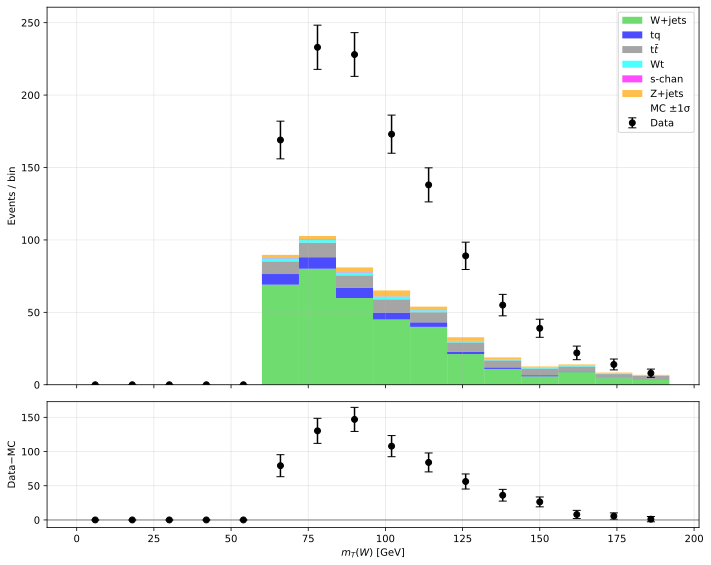

In [ ]:
# Plots MWT
plot_WT(data, dataMC, weights, dataMCtq, weightstq, dataMCtt, weightstt, dataMCWt, weightsWt, dataMCs, weights_s, dataMCZ, weights_Z)

In [ ]:
def plot_pt(data, 
            dataMC_Wjets, weights_Wjets, 
            dataMC_tq,    weights_tq,
            dataMC_ttbar, weights_ttbar,
            dataMC_Wt,    weights_Wt,
            dataMC_schan, weights_schan,
            dataMC_Zjets, weights_Zjets,
            MeV=0.001):
    # per-event mT
    mT_data    = data["lep_pt"][:,0] * MeV
    mT_Wjets   = dataMC_Wjets["lep_pt"][:,0] * MeV
    mT_tq      = dataMC_tq["lep_pt"][:,0]* MeV
    mT_ttbar   = dataMC_ttbar["lep_pt"][:,0]* MeV
    mT_Wt      = dataMC_Wt["lep_pt"][:,0]* MeV
    mT_schan   = dataMC_schan["lep_pt"][:,0]* MeV
    mT_Zjets   = dataMC_Zjets["lep_pt"][:,0]* MeV

    # bins & centers
    bins        = np.arange(0,200,12)
    bin_centers = 0.5*(bins[1:]+bins[:-1])

    # data histogram + errors
    dat_counts, _ = np.histogram(mT_data, bins=bins)
    dat_errors    = np.sqrt(dat_counts)

    # MC histograms individually
    cnt_Wjets, _  = np.histogram(mT_Wjets,  bins=bins, weights=weights_Wjets)
    cnt_tq, _     = np.histogram(mT_tq,     bins=bins, weights=weights_tq)
    cnt_ttbar, _  = np.histogram(mT_ttbar,  bins=bins, weights=weights_ttbar)
    cnt_Wt, _     = np.histogram(mT_Wt,     bins=bins, weights=weights_Wt)
    cnt_schan, _  = np.histogram(mT_schan,  bins=bins, weights=weights_schan)
    cnt_Zjets, _  = np.histogram(mT_Zjets,  bins=bins, weights=weights_Zjets)

    # total MC + uncertainty
    tot_mc_counts = (
        cnt_Wjets + cnt_tq + cnt_ttbar +
        cnt_Wt    + cnt_schan + cnt_Zjets
    )
    tot_mc_errors = np.sqrt(tot_mc_counts)

    # plot
    fig, (ax, axr) = plt.subplots(2,1, sharex=True, figsize=(10,8),
                                  gridspec_kw={'height_ratios':[3,1]})

    # stacked MC fill
    ax.hist(
        [mT_Wjets, mT_tq, mT_ttbar, mT_Wt, mT_schan, mT_Zjets],
        bins=bins,
        weights=[
            weights_Wjets, weights_tq, weights_ttbar,
            weights_Wt,    weights_schan, weights_Zjets
        ],
        stacked=True,
        color=[
            'limegreen','blue','gray',
            'cyan','magenta','orange'
        ],
        label=[
            'W+jets','tq',r't$\bar{t}$',
            'Wt','s‑chan','Z+jets'
        ],
        alpha=0.7,
    )

    # MC +/- 1 sigma
    ax.bar(
        bin_centers,
        2*tot_mc_errors,
        bottom=tot_mc_counts - tot_mc_errors,
        width=bins[1]-bins[0],
        hatch='////',
        color='none',
        alpha=0.5,
        label='MC ±1σ'
    )

    # data points
    ax.errorbar(
        bin_centers, dat_counts, yerr=dat_errors,
        fmt='o', color='k', capsize=4, label='Data'
    )

    ax.set_ylabel('Events / bin')
    ax.legend()
    ax.grid(alpha=0.3)

    # residuals
    resid      = dat_counts - tot_mc_counts
    resid_errs = np.sqrt(dat_errors**2 + tot_mc_errors**2)
    axr.errorbar(
        bin_centers, resid, yerr=resid_errs,
        fmt='o', color='k', capsize=4
    )
    axr.axhline(0, color='gray', linewidth=1)
    axr.set_ylabel('Data−MC')
    axr.set_xlabel(r'$p_{T}^{lep}$ [GeV]')
    axr.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()



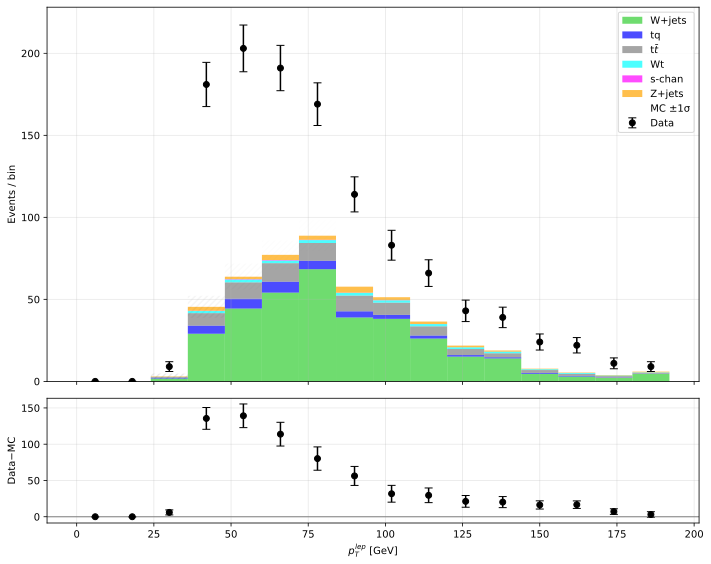

In [ ]:
# Plots pTlep
plot_pt(data, dataMC, weights, dataMCtq, weightstq, dataMCtt, weightstt, dataMCWt, weightsWt, dataMCs, weights_s, dataMCZ, weights_Z)